<a href="https://colab.research.google.com/github/salaz055/JohnSalazar/blob/main/MedicalAbstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Abstract Classifier

The purpose is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating is https://arxiv.org/abs/1710.06071

The model used to find the best results is below:
https://arxiv.org/abs/1612.05251

## Access to GPU

In [ ]:
!nvidia-smi

Mon Dec 19 17:02:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the data

Since I will need to replicate the experiment above, let's download the dataset

I can do so from the authors Github
https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone  https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start the experiments using the 20k datasets with numbers replaced with @
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocess data
One of the best ways to become one with the data is to visualize it.

In [ ]:
# Create the function to read lines of a document

def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename , 'r') as f:
    return f.readlines()
    


In [ ]:
# Let's try out the function
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 


How I think the data will be best represented...
```
[{'line_number' :0,
    'target' : 'BACKGROUND',
    'text' : 'Emotional eating is    associated with overeating and the development of obesity.',
    'total_lines': 11} .....]

```

Total lines refers to the amount of lines in the abstract

## Creating a preprocessing function

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples





In [ ]:
# Get the data from the file and preprocess it.
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

CPU times: user 347 ms, sys: 92.3 ms, total: 439 ms
Wall time: 440 ms


In [ ]:
len(train_samples) , len(test_samples) , len(val_samples)

(180040, 30135, 30212)

In [ ]:
# Check the first abstract of the training data
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Visualizing the preprocessed data in a dataframe

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


## Looking at the distribution of labels


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

## Checking the length of different lines


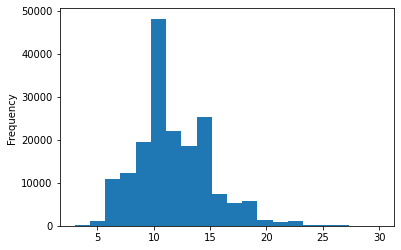

In [ ]:
train_df.total_lines.plot.hist(bins = 20)

## Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

## Turning labels into a numeric form

ML models require numeric labels


In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1 , 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1 , 1))

## Label encode labels


In [ ]:
# Extract the labels (target coloumns) and encode them into intergets
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Models

## Model 0: A baseline (TF-IDF Multinomial Naive Bayes classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Create a pipeline
model_0 = Pipeline([
  ('tf-idf' , TfidfVectorizer()),
  ('clf' , MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences ,
            y = train_labels_encoded)



Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline model on validation dataset
model_0.score(X = val_sentences , 
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
### Download the helper function script 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-19 17:15:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-19 17:15:29 (75.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Turn the text into numeric format (preparing for deep sequence models)

Create an embedding based upon tokenized words.

Vectorization and embedding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

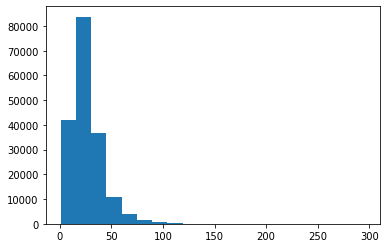

In [ ]:
# Whats the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_len, bins = 20);

In [ ]:
# What length sentence covers 95% of the data?
output_seq_len = int(np.percentile(sent_len , 95))
output_seq_len

55

In [ ]:
# Maximum sequence length
max(sent_len)

296

### Text vectorization layer

I want a layer which maps the text from words to numbers

In [ ]:
# How many words are in the vocabulary? (taken from table 2 in paper)
max_tokens = 68000


In [ ]:
#Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized Text: {text_vectorizer([target_sentence])}")


Text:
patients randomized to propofol showed more episodes of hypoxemia ( @ vs. @ % , p = @ ) and hypotension ( @ vs. @ % , p < @ ) .

Length of text: 32

Vectorized Text: [[  12   29    6  914  147   69 1056    4 5742   44   14    3 1963   44
    14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


### How many words in the training vocabulary?

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")


Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


Get the config of the text vectorizer

In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create a custom embedding layer

The text vectorizer converts words to numbers but DOES NOT capture the relationship between those numbers

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                output_dim = 128,
                                mask_zero = True,
                                name = "token_embedding")


In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 patients randomized to propofol showed more episodes of hypoxemia ( @ vs. @ % , p = @ ) and hypotension ( @ vs. @ % , p < @ ) .

Sentence after vectorization (before embedding):
 [[  12   29    6  914  147   69 1056    4 5742   44   14    3 1963   44
    14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.03294623 -0.03857844 -0.00996039 ... -0.01129782  0.03282722
   -0.04700115]
  [ 0.00414632 -0.02437282 -0.04162266 ... -0.007971   -0.02339361
    0.03843881]
  [ 0.03679341 -0.02122033 -0.03957995 ... -0.01869982  0.03275109
    0.04481851]
  ...
  [-0.04560157 -0.01423783  0.0281553  ... -0.02474705 -0.01533588
   -0.0052526 ]
  [-0.04560157 -0.01423783  0.0281553  ... -0.02474705 -0.01533588
   -0.0052526 ]
  [-0.04560157 -0.01423783  0.0281553  ... -0.02474705 

### Creating datasets (making sure the data loads as fast as possible)

I'm going to set up the data to run as fast as possible with the Tensorflow tf.dataAPI, many of the the steps are discussed in these two resources.




In [ ]:
# Turn the data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset



<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,) , dtype = tf.string)
text_vectors = text_vectorizer(inputs) # verctorize the text inputs
token_embeddings = token_embed(text_vectors) # create the embeddings
x = layers.Conv1D(64 , kernel_size = 5, padding = 'same' , activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs , outputs)

# Compile
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])



In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches                              

Epoch 1/3
562/562 [==============================] - 14s 10ms/step - loss: 0.9160 - accuracy: 0.6405 - val_loss: 0.6819 - val_accuracy: 0.7430
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6594 - accuracy: 0.7527 - val_loss: 0.6310 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6196 - accuracy: 0.7709 - val_loss: 0.5961 - val_accuracy: 0.7879


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5995 - accuracy: 0.7866


[0.5994637608528137, 0.7866079807281494]

In [ ]:
# Generate the predictions (prediction probabilities)
model_1_pred_probs = model_1.predict(valid_dataset)

# Convert pred prods to classes
model_1_preds = tf.argmax(model_1_pred_probs , axis =1)
model_1_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.66079703429101,
 'precision': 0.7831050940645707,
 'recall': 0.7866079703429101,
 'f1': 0.7840474876468563}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

The model improved dramatically in all metrics compared to the base model (Multinomial Naives Bayes)

## Model 2: A Tensorflow Hub feature extractor with pretrained token embeddings

Now let's use pretrained word embeddings from Tensorflow Hub. More specifically the universal sentence encoder

https://tfhub.dev/google/universal-sentence-encoder/4

I'm going to stick with the later created USE embeddings.

Hugging face for more pretrained models

https://huggingface.co/models


In [ ]:
# Download the pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [ ]:
# Test out the pretrained sentence embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence]) # We can pass text directly. No need to pass to a text vectorization layer first
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence: 
 clinicaltrials.gov : nct@ , @ april @ @ .
Sentence after embedding:
[-0.00174534 -0.00273945  0.09785893 -0.0089642  -0.02484377  0.06439739
 -0.0362471   0.01182271 -0.04710772 -0.06577238 -0.0090582  -0.07907109
  0.00991027  0.08052494  0.033532    0.02365818 -0.02402468 -0.01238231
  0.04823853 -0.04409944 -0.01359891 -0.00936502 -0.00266661 -0.03823173
 -0.0933191  -0.02472186 -0.05512194  0.00903879 -0.01759215  0.07629112]
Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub
 

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape = [] , dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128 , activation = 'relu')(pretrained_embedding)
# You could add more layers if you want to
outputs = layers.Dense(num_classes , activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9150 - accuracy: 0.6509 - val_loss: 0.7948 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7686 - accuracy: 0.7016 - val_loss: 0.7555 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7521 - accuracy: 0.7114 - val_loss: 0.7392 - val_accuracy: 0.7131


In [ ]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7406 - accuracy: 0.7138


[0.7406010627746582, 0.7138223052024841]

In [ ]:
# Make some predictions
# Generate the predictions (prediction probabilities)
model_2_pred_probs = model_2.predict(valid_dataset)

# Convert pred prods to labels
model_2_preds = tf.argmax(model_2_pred_probs , axis =1)
model_2_preds

945/945 [==============================] - 9s 10ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.38223222560572,
 'precision': 0.7140500163952568,
 'recall': 0.7138223222560572,
 'f1': 0.7107770183083022}

## Model 3: Conv1D with character embeddings

The paper states they used a combo of token and character level embeddings.

Previously, I used token level embeddings but I will need to do similar steps for characters if I want to use char-level embeddings


### Create a character level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return " ".join(list(text))

# Text Splitting non-character level sequence into characters
split_chars(random_train_sentence)

'c l i n i c a l t r i a l s . g o v   :   n c t @   ,   @   a p r i l   @   @   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

### Looking at the character level distributions

In [ ]:
# Whats the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

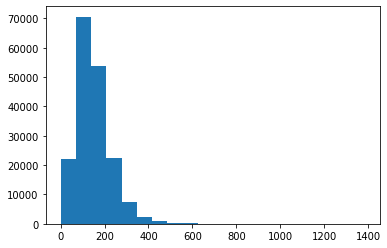

In [ ]:
# Check the distribution of the sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens , bins =20);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens , 95))
output_seq_char_len

290

### Create char-level token vectorizer instance

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 for space and OOV token (Out of vocab ["UNK"])
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)


In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized Chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 s a p r o p t e r i n   ,   a n   o r a l   s y n t h e t i c   a n a l o g u e   o f   b h @   ,   a t   t h e   u s e d   d o s e   d i d   n o t   r e d u c e   p o r t a l   p r e s s u r e   i n   p a t i e n t s   w i t h   c i r r h o s i s   .
Length of random_train_chars: 104

Vectorized Chars:
 [[ 9  5 14  8  7 14  3  2  8  4  6  5  6  7  8  5 12  9 19  6  3 13  2  3
   4 11  5  6  5 12  7 18 16  2  7 17 22 13  5  3  3 13  2 16  9  2 10 10
   7  9  2 10  4 10  6  7  3  8  2 10 16 11  2 14  7  8  3  5 12 14  8  2
   9  9 16  8  2  4  6 14  5  3  4  2  6  3  9 20  4  3 13 11  4  8  8 13
   7  9  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 

### Create the character level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25 ,
                              mask_zero = True,
                              name = 'char_embed')


In [ ]:
# Test out the character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 s a p r o p t e r i n   ,   a n   o r a l   s y n t h e t i c   a n a l o g u e   o f   b h @   ,   a t   t h e   u s e d   d o s e   d i d   n o t   r e d u c e   p o r t a l   p r e s s u r e   i n   p a t i e n t s   w i t h   c i r r h o s i s   .

Embedded chars (after vectorization and embedding):
 [[[ 0.02481511  0.00158959  0.01577851 ... -0.01074549 -0.02244039
   -0.01494753]
  [ 0.04021137 -0.02773662  0.03254927 ... -0.01799086  0.01653688
   -0.00580022]
  [-0.02038038  0.00724634 -0.03745086 ...  0.00055789  0.02488076
    0.02015156]
  ...
  [ 0.03698153 -0.02083775  0.02202702 ...  0.0380294   0.04870517
   -0.00615656]
  [ 0.03698153 -0.02083775  0.02202702 ...  0.0380294   0.04870517
   -0.00615656]
  [ 0.03698153 -0.02083775  0.02202702 ...  0.0380294   0.04870517
   -0.00615656]]]
Character embedding shape: (1, 290, 25)


### Building Model 3

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,) , dtype = tf.string)
char_vectors = char_vectorizer(inputs) # verctorize the text inputs
char_embeddings = char_embed(char_vectors) # create the embeddings
x = layers.Conv1D(64 , kernel_size = 5, padding = 'same' , activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x) # condense the output
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs = inputs , outputs = outputs , name = "model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss = "categorical_crossentropy" , 
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [ ]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

### Create char level datasets


In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars , train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars , val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars , test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fit Model 3

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2633 - accuracy: 0.4937 - val_loss: 1.0331 - val_accuracy: 0.5931
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9904 - accuracy: 0.6027 - val_loss: 0.9227 - val_accuracy: 0.6217
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9076 - accuracy: 0.6446 - val_loss: 0.8499 - val_accuracy: 0.6659


### Predictions with model 3

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.1366614 , 0.42908508, 0.18378803, 0.22924183, 0.02122376],
       [0.15081756, 0.6104127 , 0.01694288, 0.15371087, 0.06811604],
       [0.0699271 , 0.18459074, 0.05921027, 0.6538444 , 0.03242746],
       ...,
       [0.01684124, 0.02348465, 0.15309003, 0.05635588, 0.75022817],
       [0.02713533, 0.07823037, 0.45144323, 0.03160518, 0.4115858 ],
       [0.29767895, 0.5982461 , 0.04706093, 0.05147812, 0.00553587]],
      dtype=float32)

In [ ]:
# Convert prediction probabilites to class labels
model_3_preds = tf.argmax(model_3_pred_probs , axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [ ]:
# Calculate results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)

model_3_results


{'accuracy': 66.18562160730835,
 'precision': 0.6586884158609747,
 'recall': 0.6618562160730835,
 'f1': 0.6518990175538877}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

As expected, a model that ONLY takes in the character embeddings does not perform as well as a model that uses word embeddings as input.

## Model 4: Using combined Token AND character embreddings in the model (Multi-Input)

1. Create a token level embedding (similar to model 1)
2. Create a character level embedding (similar to model 3 with slight modificaiton)
3. Combine 1 & 2 with a concatenate ('layers.Concatenate')
4. Build a series of output layers on top of 3 similar to figure 1 in the paper.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


### Creating the model

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape = [] , dtype = tf.string , name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)



In [ ]:
# 2. Create the Character level embedding/model
char_inputs = layers.Input(shape = (1,) , dtype = tf.string , name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [ ]:
# 3. Concatenating the layers (hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

In [ ]:
# 4. Create the outputput layers - adding in the Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128 , activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes , activation = 'softmax')(final_dropout)



In [ ]:
# 5. Construct the model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input , char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

### Plot the hybrid model

In [ ]:
from keras.utils.vis_utils import plot_model

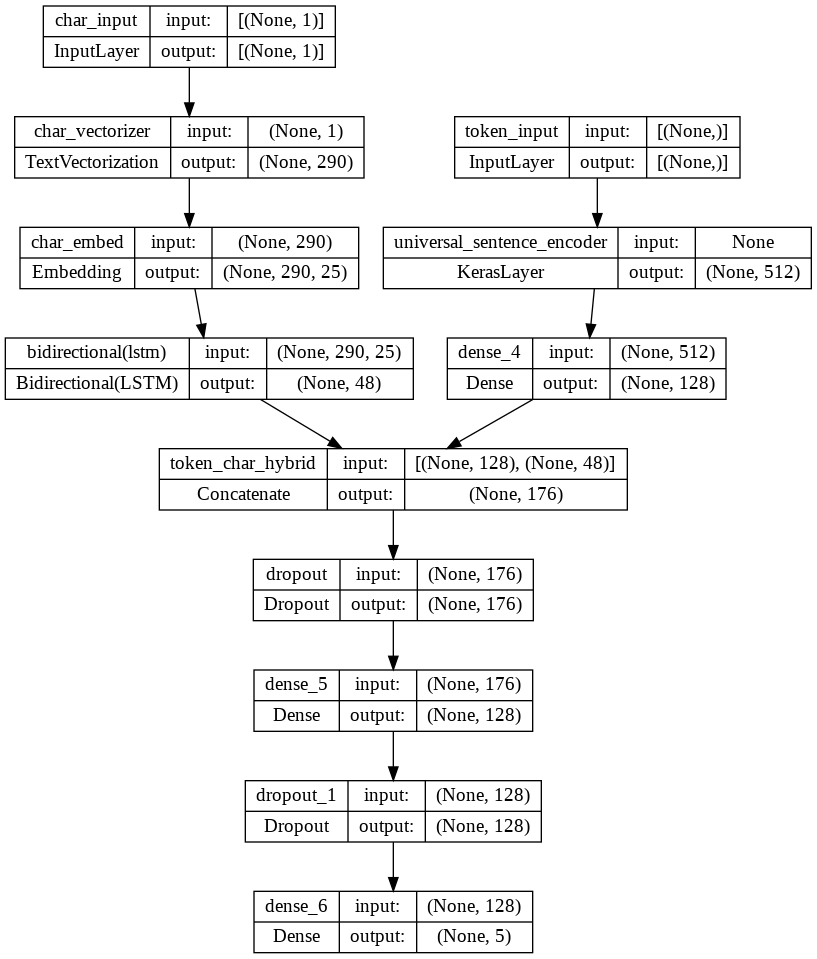

In [ ]:
plot_model(model_4 , show_shapes=True)

### Compile the model


In [ ]:
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Creating the tf.data.Dataset for training and validation data

In [ ]:
# Combine the tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences , train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data , train_char_token_labels))

# Prefetch and batch the train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Repeat the above steps for the validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences , val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data , val_char_token_labels))

# Prefetch
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check out the training char and token embedding dataset
train_char_token_dataset , val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(train_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 67ms/step - loss: 0.9917 - accuracy: 0.6027 - val_loss: 0.7832 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 35s 62ms/step - loss: 0.8026 - accuracy: 0.6888 - val_loss: 0.7124 - val_accuracy: 0.7301
Epoch 3/3
562/562 [==============================] - 32s 58ms/step - loss: 0.7789 - accuracy: 0.7031 - val_loss: 0.6956 - val_accuracy: 0.7341


### Make predictions and evaluate


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.7012 - accuracy: 0.7325


[0.7012079954147339, 0.7324904203414917]

In [ ]:
# Make predictions using the hybrid model (model 4)
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs


945/945 [==============================] - 22s 21ms/step


array([[4.0956268e-01, 4.0647382e-01, 5.4622726e-03, 1.7133400e-01,
        7.1672117e-03],
       [3.7981451e-01, 4.1010749e-01, 4.0190271e-03, 2.0252965e-01,
        3.5293172e-03],
       [2.8533500e-01, 1.7605902e-01, 5.5963185e-02, 4.4254512e-01,
        4.0097632e-02],
       ...,
       [4.9774605e-04, 8.8868113e-03, 5.3856906e-02, 2.0492528e-04,
        9.3655366e-01],
       [5.9419656e-03, 5.8658563e-02, 2.3925146e-01, 3.3715253e-03,
        6.9277650e-01],
       [2.5705260e-01, 4.2219847e-01, 2.1579789e-01, 3.3448935e-02,
        7.1502067e-02]], dtype=float32)

In [ ]:
# Format pred probs into labels
model_4_preds = tf.argmax(model_4_pred_probs , axis = 1)
model_4_preds 

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate the results
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)

In [ ]:
model_4_results

{'accuracy': 73.24904011651,
 'precision': 0.7337774097852174,
 'recall': 0.7324904011651,
 'f1': 0.7289331996353138}

## Model 5 (Adding Positional Embeddings)

* Feature Engineering
* Taking non-obvious features from the data and encoding them numerically
* Engineered Features need to available at test time. Linenumbers and the total number of line IS available




In [ ]:
# Check out the first abstract of the training data
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

### Examining the distribuition of line numbers

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

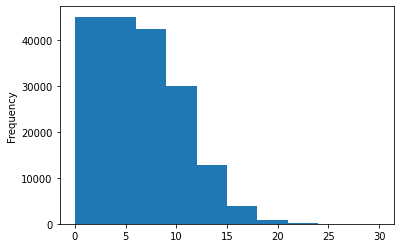

In [ ]:
# Check the distribution of line number column
train_df.line_number.plot.hist()

### Use TF to create one-hot-encoded tensors for line numbers

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy() , depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy() , depth = 15)


test_line_numbers_one_hot[:14] , test_line_numbers_one_hot.shape


(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.

### Use TF to create one-hot-encoded tensors for total lines

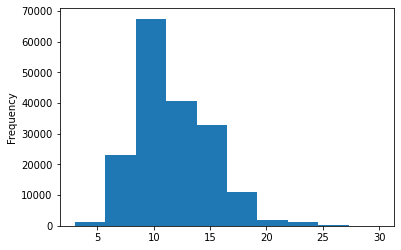

In [ ]:
# Plot the distribution
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of total_lines set to depth 20
np.percentile(train_df.total_lines , 98)

20.0

In [ ]:
# One hot encoding

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy() , depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy() , depth = 20)


train_total_lines_one_hot[:10] , train_total_lines_one_hot.shape


(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building Model 5

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number feature"
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the output of 3 , 4 , 5 using tf.keras.layers.Concatenate
7. Create the output layer to accept the tribried embedding and output the label probabilities.
8. Combine the inputs of 1 , 2 ,3 ,4 and outputs of 7 into a tf.keras.Model


In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape = [] , dtype = "string" , name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1, ) , dtype = "string" , name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line Numbers Model
line_number_inputs = layers.Input(shape = (15,) , dtype = tf.float32, name = "line_number_input")
x = layers.Dense(32 , activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total Lines
total_lines_inputs = layers.Input(shape = (20,) , dtype = tf.float32 , name = 'total_lines_input')
y = layers.Dense(32 , activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)

# 5. Combine 1 and 2 (token and char embeddings)
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output , char_model.output])


z = layers.Dense(256 , activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
# 6. Combine the outputs of 3 , 4 ,5 (combine the positional embeddings with already combined token/char embeddings)
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output ,
                                                                                   total_lines_model.output,
                                                                                   z])

# 7. Create output layer
output_layer = layers.Dense(5 , activation = "softmax" , name = "output_layer")(tribrid_embeddings)

# 8. Put it all together in a model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "model_5_tribred_embedding_model")




### Examining Model 5

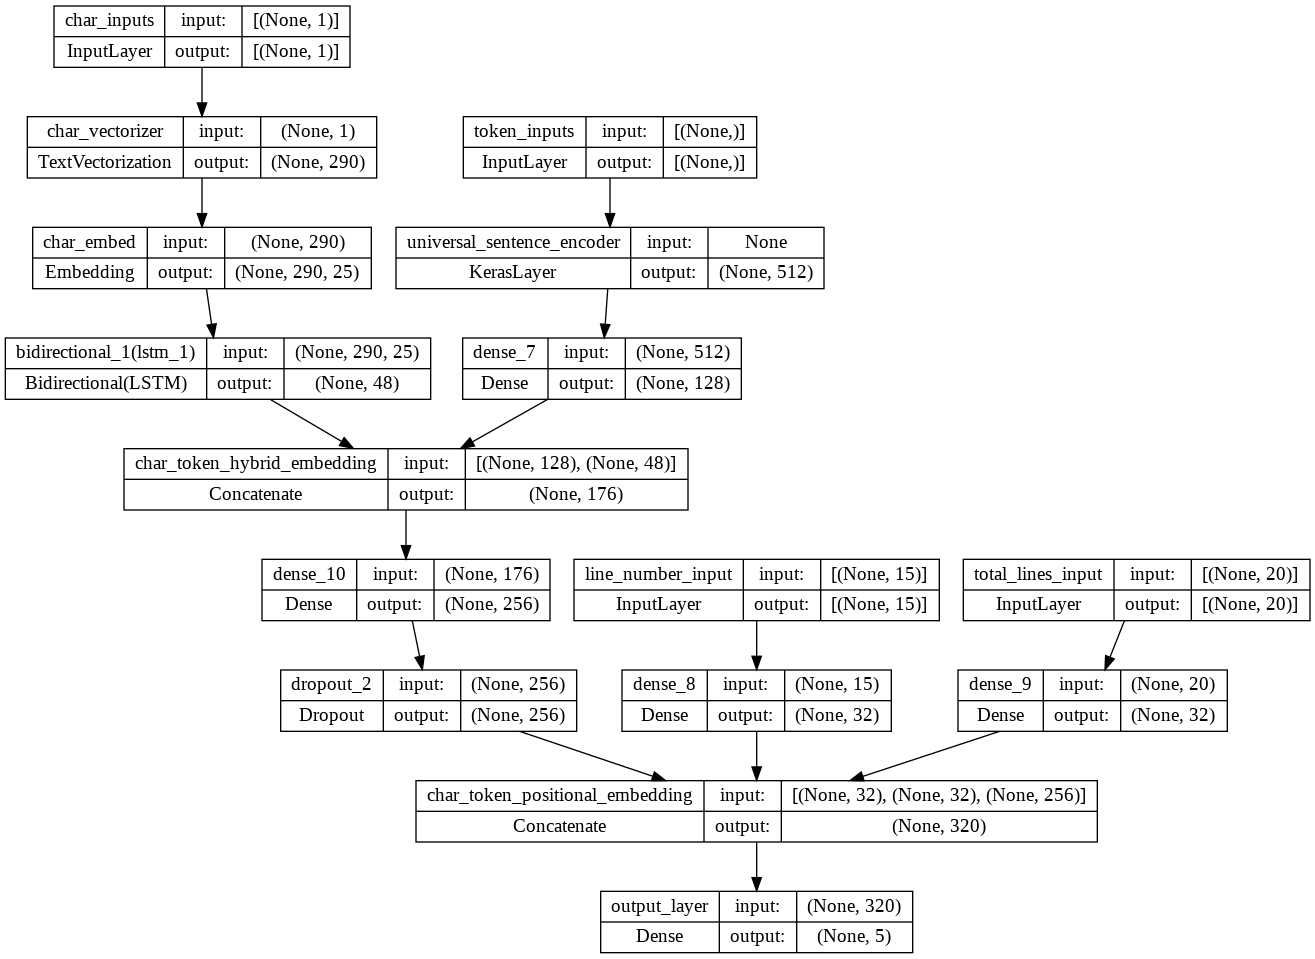

In [ ]:
plot_model(model_5 , show_shapes=True)

### Compile model 5


In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # label smoothing helps prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

If the model gets too confident on a single class (ed its prediction probability is really high) , it may get stuck on that class and not consider other classes.

Really confident prediction probabilities: `[0.0 , 0.0 , 1.0 , 0.0 , 0.0]`

Label smoothing assigns some of the value from the highest pred prob to other classes, hopefully improving generalization `[0.0 , 0.01 , 0.96 , 0.01 , 0.02]`


### Create tribrid embedding datasets using tf.data

Create training and validation datasets (all four kinds of input data)

In [ ]:
# Creating datasets for training data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data , train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Doing the same for validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data , val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check the input shapes
train_char_token_pos_dataset , val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting Model 5

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                              epochs = 15)


Epoch 1/15
562/562 [==============================] - 37s 52ms/step - loss: 1.0955 - accuracy: 0.7251 - val_loss: 0.9817 - val_accuracy: 0.8059
Epoch 2/15
562/562 [==============================] - 27s 49ms/step - loss: 0.9664 - accuracy: 0.8163 - val_loss: 0.9497 - val_accuracy: 0.8261
Epoch 3/15
562/562 [==============================] - 25s 44ms/step - loss: 0.9482 - accuracy: 0.8250 - val_loss: 0.9416 - val_accuracy: 0.8371
Epoch 4/15
562/562 [==============================] - 27s 48ms/step - loss: 0.9406 - accuracy: 0.8333 - val_loss: 0.9306 - val_accuracy: 0.8334
Epoch 5/15
562/562 [==============================] - 26s 46ms/step - loss: 0.9362 - accuracy: 0.8364 - val_loss: 0.9256 - val_accuracy: 0.8408
Epoch 6/15
562/562 [==============================] - 25s 45ms/step - loss: 0.9406 - accuracy: 0.8307 - val_loss: 0.9202 - val_accuracy: 0.8461
Epoch 7/15
562/562 [==============================] - 28s 50ms/step - loss: 0.9275 - accuracy: 0.8420 - val_loss: 0.9224 - val_accuracy:

562/562 [==============================] - 3s 4ms/step - loss: 0.9373 - accuracy: 0.8350 - val_loss: 0.9107 - val_accuracy: 0.8487


###Evaluation and Predictions

In [ ]:
# Make predictions with the model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)

# Convert pred probs to labels
model_5_preds = tf.argmax(model_5_pred_probs , axis = 1)

# Calculate results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)


945/945 [==============================] - 22s 21ms/step


In [ ]:
model_5_results

{'accuracy': 83.5032437442076,
 'f1': 0.8341416997916474,
 'precision': 0.83422043964078,
 'recall': 0.835032437442076}

**The model has achieved 83% accuracy with 10% of the training data.**

## Comparing the models

In [ ]:
import pandas as pd
all_model_results = pd.DataFrame([baseline_results , model_1_results , model_2_results , model_3_results , model_4_results , model_5_results], index = ['model_0_baseline_results' , 'model_1_custom_token_embedding' , 'model_2_pretrained_token_embedding', 'model_3_custom_char_embedding' , 'model_4_hybrid_char_token_embedding' , 'model_5_pos_char_token_embedding'])


In [ ]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline_results,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.660797,0.783105,0.786608,0.784047
model_2_pretrained_token_embedding,71.382232,0.714050,0.713822,0.710777
model_3_custom_char_embedding,66.185622,0.658688,0.661856,0.651899
model_4_hybrid_char_token_embedding,73.249040,0.733777,0.732490,0.728933
model_5_pos_char_token_embedding,85.068847,0.851944,0.850688,0.847460


In [ ]:
# Reduce the accuracy to same scal as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

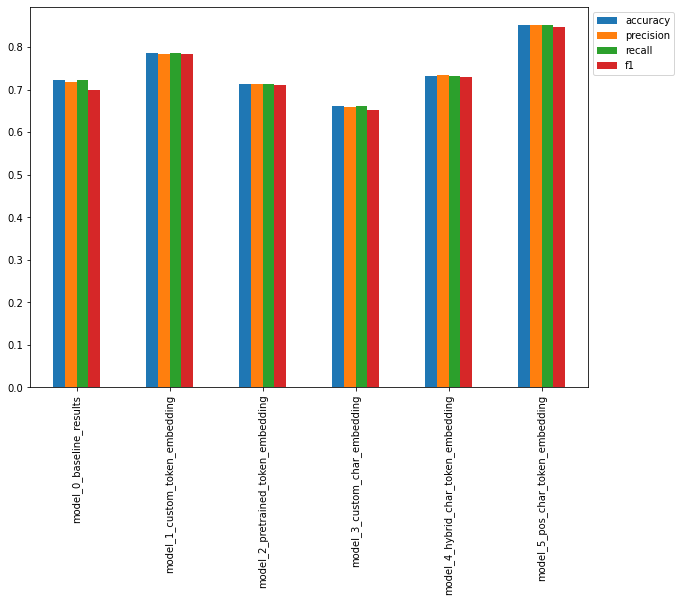

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind = 'bar' , figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0));

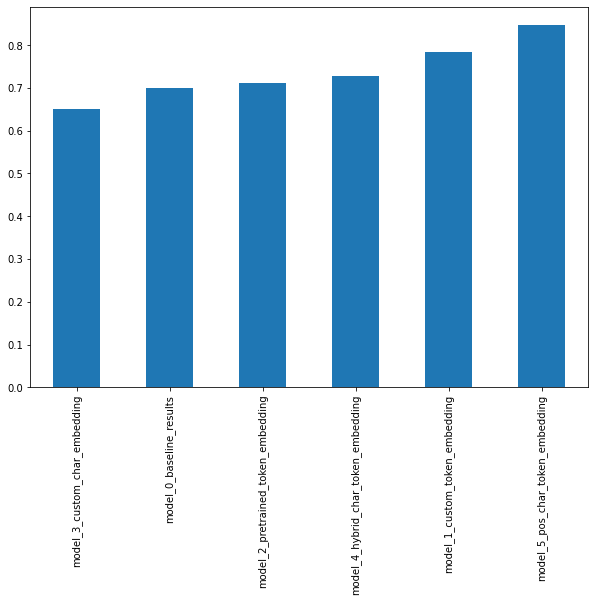

In [ ]:
# Sort the models f1-scores
all_model_results.sort_values("f1" , ascending = True)['f1'].plot(kind = "bar" , figsize = (10,7))

## Saving and loading model 5

In [ ]:
model_5.save("skimlit_tribrid_model")


In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs , axis = 1)
loaded_preds

945/945 [==============================] - 24s 22ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
loaded_preds[:10]


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate results of loaded model
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)
loaded_model_results

{'accuracy': 85.06884681583476,
 'precision': 0.8519438414614544,
 'recall': 0.8506884681583476,
 'f1': 0.8474604486066846}

In [ ]:
model_5_results

{'accuracy': 85.06884681583476,
 'precision': 0.8519438414614544,
 'recall': 0.8506884681583476,
 'f1': 0.8474604486066846}